# NESTML dopamine-modulated STDP synapse tutorial

<i>Some text in this this section is copied verbatim from [1].</i>

Pavlov and Thompson (1902) firs described classical conditioning: a phenomenon in which a biologically potent stimulus–the Unconditional Stimulus (UC)—is initially paired with a neutral stimulus—the Conditional Stimulus CS). After many trials, learning is observed when the previously neutral stimuli starts to elicit a response similar to that which was previously only elicited by the biologically potent stimulus. Pavlov and Thompson performed many experiments with dogs, observing their response (by monitoring salivation) to the appearance of a person who has been feeding them and the actual food appearing (UC). He demonstrated that the dogs started to salivate in the presence of the person who has been feeding them (or any other CS), rather than just when the food appears, because the CS had previously been associated with food.

## Model

Izhikevich (2007) revisits an important question: how does an
animal know which of the many cues and actions preceding a
reward should be credited for the reward? Izhikevich explains
that dopamine-modulated STDP has a built-in instrumental
conditioning property, i.e., the associations between cues, actions
and rewards are learned automatically by reinforcing the firing
patterns (networks of synapses) responsible, even when the
firings of those patterns are followed by a delayed reward or
masked by other network activity. To achieve this each synapse
has an eligibility trace C:

$$
\frac{dC}{dt} = -\frac{C}{\tau_C} + \text{STDP}(\Delta t)\delta(t - t_\text{pre/post}) \quad \text{(1)}
$$

where τc is the decay time constant of the eligibility trace and
$\text{STDP}(\Delta t)$ represents the magnitude of the change to make to the
eligibility trace in response to a pair of pre- and post-synaptic
spikes with temporal difference $\Delta t = t_\text{post} − t_\text{pre}$. Finally, $\delta(t − t_\text{pre/post})$ is a Dirac delta function used to apply the effect of STDP to the trace at the times of pre- or post-synaptic spikes. The concentration of Dopamine is described by a variable $D$:

$$
\frac{dD}{dt} = − \frac{D}{\tau_d} + D_c \sum_{t_d^f} \delta(t - t_d^f) \quad \text{(2)}
$$

where $\tau_d$ is the time constant of dopamine re-absorption, $D_c$ is
the increase in dopamine concentration caused by each incoming
dopaminergic spike and $t_d^f$ are the times of these spikes.
Equations (1, 2) are then combined to calculate the change in
synaptic strength W:
$$
\frac{dW}{dt} = CD  \quad \text{(3)}
$$

As discussed in section 1, when a post-synaptic spike arrives
very shortly after a pre-synaptic spike, a standard STDP rule
would immediately potentiate the synaptic strength. However,
as Figure 2 illustrates, when using the three-factor STDP rule,this potentiation would instead be applied to the eligibility trace.
Because changes to the synaptic strength are gated by dopamine
concentration $D$ (Equation 4), changes are only made to the
synaptic strength if $D \neq 0$. Furthermore, if the eligibility trace
has decayed back to 0 before any dopaminergic spikes arrive, the
synaptic strength will not be changed



In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = [8., 3.]

import matplotlib.pyplot as plt
import nest
import numpy as np
import os
import random
import re
from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

## Generating code with NESTML

### Formulating the model in NESTML

To generate fast code, NESTML needs to process the synapse model together with the neuron model that will be its postsynaptic partner in the network instantiantion.

In this tutorial, we will use a very simple integrate-and-fire model, where arriving spikes cause an instantaneous increment of the membrane potential.

We now define a helper function to generate the C++ code for the models, build it as a NEST extension module, and load the module into the kernel. The resulting model names are composed of associated neuron and synapse partners, because of the co-generation, for example, "stdp_synapse__with_iaf_psc_delta" and "iaf_psc_delta__with_stdp_synapse".

Because NEST does not support un- or reloading of modules at the time of writing, we implement a workaround that appends a unique number to the name of each generated model, for example, "stdp_synapse0__with_iaf_psc_delta0" and "iaf_psc_delta0__with_stdp_synapse0".

The resulting neuron and synapse model names are returned by the function, so we do not have to think about these internals.

In [2]:
n_modules_generated = 0
def generate_code_for(nestml_synapse_model: str):
    """Generate code for a given synapse model, passed as a string, in combination with
    the iaf_psc_delta model.
    
    NEST cannot yet reload modules. Workaround using counter to generate unique names."""
    global n_modules_generated
   
    # append digit to the neuron model name and neuron model filename
    with open("models/neurons/iaf_psc_delta.nestml", "r") as nestml_model_file_orig:
        nestml_neuron_model = nestml_model_file_orig.read()
        nestml_neuron_model = re.sub("neuron\ [^:\s]*:",
                                     "neuron iaf_psc_delta" + str(n_modules_generated) + ":", nestml_neuron_model)
        with open("models/neurons/iaf_psc_delta" + str(n_modules_generated) + ".nestml", "w") as nestml_model_file_mod:
            print(nestml_neuron_model, file=nestml_model_file_mod)

    # append digit to the synapse model name and synapse model filename
    nestml_synapse_model_name = re.findall("synapse\ [^:\s]*:", nestml_synapse_model)[0][8:-1]
    nestml_synapse_model = re.sub("synapse\ [^:\s]*:",
                                  "synapse " + nestml_synapse_model_name + str(n_modules_generated) + ":", nestml_synapse_model)
    with open("models/synapses/" + nestml_synapse_model_name + str(n_modules_generated) + ".nestml", "w") as nestml_model_file:
        print(nestml_synapse_model, file=nestml_model_file)

    # generate the code for neuron and synapse (co-generated)
    module_name = "nestml_" + str(n_modules_generated) + "_module"
    generate_nest_target(input_path=["models/neurons/iaf_psc_delta" + str(n_modules_generated) + ".nestml",
                                     "models/synapses/" + nestml_synapse_model_name + str(n_modules_generated) + ".nestml"],
                         target_path="/tmp/nestml_module",
                         logging_level="ERROR",
                         module_name=module_name,
                         suffix="_nestml",
                         codegen_opts={"nest_path": NEST_SIMULATOR_INSTALL_LOCATION,
                                       "neuron_parent_class": "StructuralPlasticityNode",
                                       "neuron_parent_class_include": "structural_plasticity_node.h",
                                       "neuron_synapse_pairs": [{"neuron": "iaf_psc_delta" + str(n_modules_generated),
                                                                   "synapse": nestml_synapse_model_name + str(n_modules_generated),
                                                                   "post_ports": ["post_spikes"],
                                                                   "vt_ports": ["mod_spikes"]}]})
    
    # load module into NEST
    nest.ResetKernel()
    nest.Install(module_name)

    mangled_neuron_name = "iaf_psc_delta" + str(n_modules_generated) + "_nestml__with_" + nestml_synapse_model_name + str(n_modules_generated) + "_nestml"
    mangled_synapse_name = nestml_synapse_model_name + str(n_modules_generated) + "_nestml__with_iaf_psc_delta" + str(n_modules_generated) + "_nestml"

    n_modules_generated += 1
    
    return mangled_neuron_name, mangled_synapse_name

We now go on to define the full synapse model in NESTML:

In [78]:
nestml_stdp_dopa_model = """
synapse neuromodulated_stdp:

  state:
    w real = 1.
    n real = 0.   # Neuromodulator concentration
    c real = 0.   # Eligibility trace
    pre_tr real = 0.
    post_tr real = 0.
  end

  parameters:
    the_delay ms = 1 ms  @nest::delay   # !!! cannot have a variable called "delay"
    tau_tr_pre ms = 20 ms   # STDP time constant for weight changes caused by pre-before-post spike pairings.
    tau_tr_post ms = 20 ms    # STDP time constant for weight changes caused by post-before-pre spike pairings.
    tau_c ms = 1000 ms    # Time constant of eligibility trace
    tau_n ms = 200 ms   # Time constant of dopaminergic trace
    b real = 0.   # Dopaminergic baseline concentration
    Wmax real = 200.    # Maximal synaptic weight
    Wmin real = 0.    # Minimal synaptic weight
    A_plus real = 1.    # Multiplier applied to weight changes caused by pre-before-post spike pairings. If b (dopamine baseline concentration) is zero, then A_plus is simply the multiplier for facilitation (as in the stdp_synapse model). If b is not zero, then A_plus will be the multiplier for facilitation only if n - b is positive, where n is the instantenous dopamine concentration in the volume transmitter. If n - b is negative, A_plus will be the multiplier for depression.
    A_minus real = 1.5    # Multiplier applied to weight changes caused by post-before-pre spike pairings. If b (dopamine baseline concentration) is zero, then A_minus is simply the multiplier for depression (as in the stdp_synapse model). If b is not zero, then A_minus will be the multiplier for depression only if n - b is positive, where n is the instantenous dopamine concentration in the volume transmitter. If n - b is negative, A_minus will be the multiplier for facilitation.
    A_vt real = 1.     # Multiplier applied to dopa spikes
  end

  equations:
    pre_tr' = -pre_tr / tau_tr_pre
    post_tr' = -post_tr / tau_tr_post
  end

  internals:
    tau_s 1/ms = (tau_c + tau_n) / (tau_c * tau_n)
  end

  input:
    pre_spikes nS <- spike
    post_spikes nS <- spike
    mod_spikes real <- spike
  end

  output: spike

  onReceive(mod_spikes):
    n += A_vt / tau_n
  end

  onReceive(post_spikes):
    post_tr += 1.

    # facilitation
    c += A_plus * pre_tr
  end

  onReceive(pre_spikes):
    pre_tr += 1.

    # depression
    c -= A_minus * post_tr

    # deliver spike to postsynaptic partner
    deliver_spike(w, the_delay)
  end

  # update from time t to t + resolution()
  update:
    # resolution() returns the timestep to be made (in units of time)
    # the sequence here matters: the update step for w requires the "old" values of c and n
    w -= c * ( n / tau_s * expm1( -tau_s * resolution() ) \
             - b * tau_c * expm1( -resolution() / tau_c ))
    w = max(0., w)
    c = c * exp(-resolution() / tau_c)
    n = n * exp(-resolution() / tau_n)
  end

end
"""

Generate the code, build the user module and make the model available to instantiate in NEST:

In [4]:
neuron_model_name, synapse_model_name = generate_code_for(nestml_stdp_dopa_model)

### Running the simulation in NEST

Let's define a function that will instantiate a simple network with one presynaptic cell and one postsynaptic cell connected by a single synapse, then run a simulation and plot the results.

In [2]:
def run_network(pre_spike_time, post_spike_time, vt_spike_times,
                          neuron_model_name,
                          synapse_model_name,
                          resolution=.1, # [ms]
                          delay=1., # [ms]
                          lmbda=1E-6,
                          sim_time=None,  # if None, computed from pre and post spike times
                          synapse_parameters=None,  # optional dictionary passed to the synapse
                          fname_snip="",
                          debug=False):

    #nest.set_verbosity("M_WARNING")
    nest.set_verbosity("M_ALL")

    nest.ResetKernel()
    nest.SetKernelStatus({'resolution': resolution})

    # create spike_generators with these times
    pre_sg = nest.Create("spike_generator",
                         params={"spike_times": [pre_spike_time]})
    post_sg = nest.Create("spike_generator",
                          params={"spike_times": [post_spike_time]})
    vt_sg = nest.Create("spike_generator",
                            params={"spike_times": vt_spike_times})

    # create  volume transmitter
    vt = nest.Create("volume_transmitter")
    vt_parrot = nest.Create("parrot_neuron")
    nest.Connect(vt_sg, vt_parrot, syn_spec={"weight": -1.})
    nest.Connect(vt_parrot, vt, syn_spec={"synapse_model": "static_synapse",
                                          "weight": 1.,
                                          "delay": 1.})   # delay is ignored?!
    vt_gid = vt.get("global_id")

    # set up custom synapse models
    wr = nest.Create('weight_recorder')
    nest.CopyModel(synapse_model_name, "stdp_nestml_rec",
                {"weight_recorder": wr[0],
                 "w": 1.,
                 "delay": delay,
                 #"d": delay,
                 "receptor_type": 0,
#                  "mu_minus": 0.,
#                  "mu_plus": 0.
                 "vt": vt_gid,
                 "tau_tr_pre": 10.,
                 #"A_vt": 1.
                })

    # create parrot neurons and connect spike_generators
    pre_neuron = nest.Create("parrot_neuron")
    post_neuron = nest.Create(neuron_model_name)
    
    #var_name = [s for s in post_neuron.get().keys() if s.startswith("post_tr")][0]
    #post_neuron.set({var_name: 10.})

    spikedet_pre = nest.Create("spike_recorder")
    spikedet_post = nest.Create("spike_recorder")
    spikedet_vt = nest.Create("spike_recorder")

    #mm = nest.Create("multimeter", params={"record_from" : ["V_m"]})

    nest.Connect(pre_sg, pre_neuron, "one_to_one", syn_spec={"delay": 1.})
    nest.Connect(post_sg, post_neuron, "one_to_one", syn_spec={"delay": 1., "weight": 9999.})
    nest.Connect(pre_neuron, post_neuron, "all_to_all", syn_spec={'synapse_model': 'stdp_nestml_rec'})
    #nest.Connect(mm, post_neuron)

    nest.Connect(pre_neuron, spikedet_pre)
    nest.Connect(post_neuron, spikedet_post)
    nest.Connect(vt_parrot, spikedet_vt)
    
    # get STDP synapse and weight before protocol
    syn = nest.GetConnections(source=pre_neuron, synapse_model="stdp_nestml_rec")
    if synapse_parameters is None:
        synapse_parameters = {}
    nest.SetStatus(syn, synapse_parameters)

    initial_weight = nest.GetStatus(syn)[0]["w"]
    np.testing.assert_allclose(initial_weight, 1)
    nest.Simulate(sim_time)
    updated_weight = nest.GetStatus(syn)[0]["w"]

    actual_t_pre_sp = nest.GetStatus(spikedet_pre)[0]["events"]["times"][0]
    actual_t_post_sp = nest.GetStatus(spikedet_post)[0]["events"]["times"][0]

    pre_spike_times_ = nest.GetStatus(spikedet_pre, "events")[0]["times"]
    #print("Actual pre spike times: " + str(pre_spike_times_))
    assert len(pre_spike_times_) == 1 and pre_spike_times_[0] > 0
    
    post_spike_times_ = nest.GetStatus(spikedet_post, "events")[0]["times"]
    #print("Actual post spike times: " + str(post_spike_times_))
    assert len(post_spike_times_) == 1 and post_spike_times_[0] > 0

    vt_spike_times_ = nest.GetStatus(spikedet_vt, "events")[0]["times"]
    #print("Actual vt spike times: " + str(vt_spike_times_))
    assert len(vt_spike_times_) == 1 and vt_spike_times_[0] > 0

    #dt = actual_t_post_sp - actual_t_pre_sp
    dt = 0.
    dw = updated_weight

    return dt, dw

Then, we can run the experiment. We set the pre spike time to a constant (100 ms) and loop over values for the post spike time (25 to 175 ms).

Note that the dendritic delay in this example has been set to 10 ms, to make its effect on the STDP window more clear: it is not centered around zero, but shifted to the left by the dendritic delay. Hint: play with the parameters a bit here and see the effects it has on the returned window.

In [3]:
def plot_vt_spike_timing_experiment(dt_vec, dw_vec, delay, pre_spike_times_, post_spike_times_, vt_spike_times_):
    fig, ax = plt.subplots(nrows=4)
    ax1, ax2, ax3, ax4 = ax

    n_spikes = len(pre_spike_times_)
    for i in range(n_spikes):
        if i == 0:
            _lbl = "nestml"
        else:
            _lbl = None
        ax1.plot(2 * [pre_spike_times_[i] + delay], [0, 1], linewidth=2, color="blue", alpha=.4, label=_lbl)

    ax1.set_ylabel("Pre spikes")

    ax2.plot(timevec, nest.GetStatus(mm, "events")[
             0]["post_tr__for_neuromodulated_stdp_nestml"], label="nestml post tr")
    n_spikes = len(post_spike_times_)
    for i in range(n_spikes):
        if i == 0:
            _lbl = "nestml"
        else:
            _lbl = None
        ax2.plot(2 * [post_spike_times_[i]], [0, 1], linewidth=2, color="black", alpha=.4, label=_lbl)
    ax2.set_ylabel("Post spikes")

    n_spikes = len(vt_spike_times_)
    for i in range(n_spikes):
        ax3.plot(2 * [vt_spike_times_[i]], [0, 1], linewidth=2, color="black", alpha=.4)
    ax3.set_ylabel("VT spikes")

    ax4.plot(t_hist, w_hist, marker="o", label="nestml")
    ax4.set_xlabel("Time [ms]")
    ax4.set_ylabel("w")

    for _ax in ax:
        _ax.grid(which="major", axis="both")
        _ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(0, np.ceil(sim_time))))
        _ax.set_xlim(0., sim_time)
        _ax.legend()
    fig.show()

In [4]:
def run_vt_spike_timing_experiment(neuron_model_name, synapse_model_name, synapse_parameters=None):
    sim_time = 10000.  # [ms] -- make sure to simulate for much longer than the eligibility trace
                      #         time constant, which is typically the slowest time constant in 
                      #         the system, PLUS the time of the latest vt spike
    pre_spike_time = 1. # [ms]
    post_spike_time = 3. # [ms]
    delay = .5 # dendritic delay [ms]

    dt_vec = []
    dw_vec = []
    for vt_spike_time in np.round(np.linspace(4, 5000, 12)).astype(float):  # sim_time - 10 * delay
        dt, dw = run_network(pre_spike_time, post_spike_time, [vt_spike_time],
                          neuron_model_name,
                          synapse_model_name,
                          delay=delay, # [ms]
                          synapse_parameters=synapse_parameters,
                          sim_time=sim_time)
        dt_vec.append(vt_spike_time)
        dw_vec.append(dw)
        
    return dt_vec, dw_vec, delay

NameError: name 'neuron_model_name' is not defined

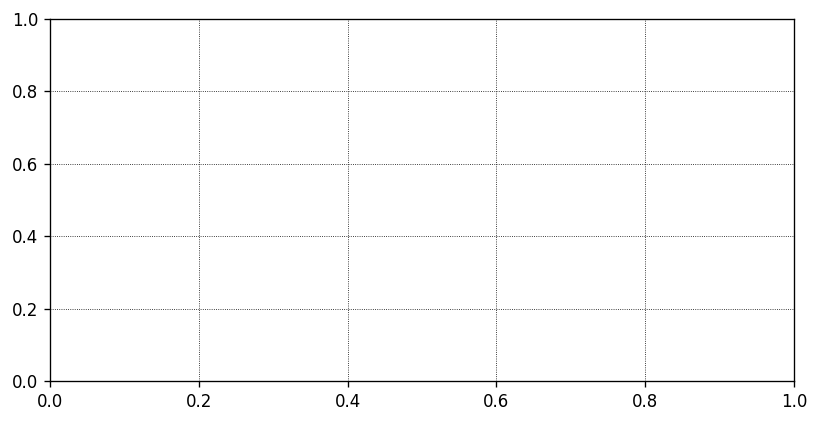

In [5]:
fig, ax = plt.subplots()
for A_vt in [1., -1.]:
    dt_vec, dw_vec, delay = run_vt_spike_timing_experiment(neuron_model_name,
                                                       synapse_model_name, 
                                                       synapse_parameters={"A_vt": A_vt})
    ax.plot(dt_vec, dw_vec, marker='o', label="$A_{vt}$ = " + str(A_vt))

ax.set_xlabel("Time of dopa spike [ms]")
ax.set_ylabel("Weight at $t = \infty$")
ax.legend()

#plot_vt_spike_timing_experiment(dt_vec, dw_vec, delay)

Learning through dopamine
----------------------

(reproducing Figure 4 from [1])

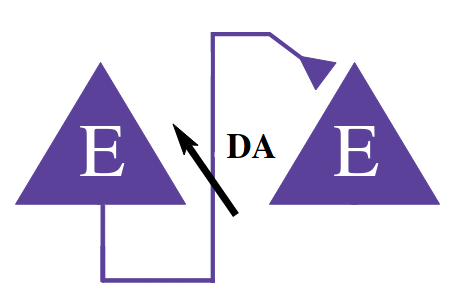

Noisy Cue-Association: Temporal Credit-Assignment Task
----------------------

Izhikevich (2007): "In Figure 2a, we illustrate a classical (Pavlovian) conditioning
experiment: Rewarding a CS (S1) embedded into a continuous
stream of a large number of irrelevant but equally salient stimuli."

demonstrated a Pavlovian conditioning experiment in which a conditioned stimulus (S1) is repeatedly injected into the sea of random neural activity and then followed by a reward, which reinforces the neural pathways going from neurons representing S1. To simulate the experiment, $N$ random sets of neurons (each representing stimulus S1 through SN) are chosen from the pool of 1,000 neurons. To deliver a stimulus to the network, we stimulated the 50 neurons representing the chosen stimulus by injecting a 1 ms pulse of super-threshold current. Next, a continuous input stream is formed consisting of stimuli Sk(1 ≤ k ≤ 100) in a random order with random intervals between 100 and 300 ms. After every presentation of S1 a reward in the form of an increase of extra-cellular dopamine is delivered to all plastic synapse in the network after a random delay of up to 1 s. The delay is large enough to allow a few irrelevant input stimuli to be presented during the waiting period—these can be considered as distractors. At the beginning of the experiment the neurons representing each stimuli Sk(1 ≤ k ≤ 100) respond equally. However, after many trials, the network starts to show reinforced response to the CS (S1). Because synapses coming out of neurons representing S1 are always tagged with the eligibility trace when the reward is delivered, whereas the synapses connected to neurons representing irrelevant stimuli will only be occasionally tagged, the average strength of synaptic connections from neurons representing stimuli S1 becomes stronger than the mean synaptic connection strength in the rest of the network. Therefore, the other neurons in the network learn to listen more closely to the stimuli S1, because the activation of this pathway causes a reward.

<img src="network_diagram.png" alt="Network diagram" width="50%">

<small><i>Figure from [2]</i></small>

In [6]:
# simulation parameters

dt = .1    # the resolution in ms
delay = 1.    # synaptic delay in ms

# parameters for balanced network

g = 4.  # ratio inhibitory weight/excitatory weight
epsilon = .1  # connection probability
NE = 800  # number of excitatory neurons
NI = 200  # number of inhibitory neurons
N_neurons = NE + NI   # number of neurons in total
N_rec = 50      # record from 50 neurons

CE = int(epsilon * NE)  # number of excitatory synapses per neuron
CI = int(epsilon * NI)  # number of inhibitory synapses per neuron
C_tot = int(CI + CE)      # total number of synapses per neuron

n_subgroups = 2  # = n_stimuli
subgroup_size = 50

# neuron parameters

tauSyn = 1.  # synaptic time constant [ms]
tauMem = 10.  # time constant of membrane potential [ms]
CMem = 300.  # capacitance of membrane [pF]

neuron_params_exc = {"C_m": CMem,
                 "tau_m": tauMem,
                 "tau_syn_exc": tauSyn,
                 "tau_syn_inh": tauSyn,
                 "t_ref": 4.0,
                 "E_L": -65.,
                 "V_reset": -70.,
                 "V_m": -65.,
                 "V_th": -55.4,
                 "I_e": 0.   # [pA]
}
neuron_params_inh = {"C_m": CMem,
                 "tau_m": tauMem,
                 "tau_syn_exc": tauSyn,
                 "tau_syn_inh": tauSyn,
                 "t_ref": 2.0,
                 "E_L": -65.,
                 "V_reset": -70.,
                 "V_m": -65.,
                 "V_th": -56.4}

# J_ex should be large enough so that when stimulus excites the subgroup cells,
# the subgroup cells cause an excitatory transient in the network to establish
# a causal STDP timing and positive eligibility trace in the synapses
J_ex = 300.  # amplitude of excitatory postsynaptic current
J_in = -g * J_ex    # amplitude of inhibitory postsynaptic current
J_poisson = 2500.
J_stim = 5000.

p_rate = 5.    # external Poisson generator rate [s^-1]

learning_rate = .1   # multiplier for weight updates

reinforced_subgroup_idx = 0
stimulus_rate = 5.   # [s^-1]

min_stimulus_presentation_delay = 10.   # [ms]

min_dopa_reinforcement_delay = 10. # [ms]
max_dopa_reinforcement_delay = 30. # [ms]

total_t_sim = 10000.  # [ms]

In [7]:
neuron_model_name = "iaf_psc_exp_nestml__with_neuromodulated_stdp_nestml"
synapse_model_name = "neuromodulated_stdp_nestml__with_iaf_psc_exp_nestml"


# generate_nest_target(input_path=["models/neurons/iaf_psc_exp_alt.nestml", "models/synapses/neuromodulated_stdp.nestml"],
#                      target_path="/tmp/nestml-jit",
#                      logging_level="WARNING",
#                      module_name="nestml_jit_module",
#                      suffix="_nestml",
#                      codegen_opts={"neuron_parent_class": "StructuralPlasticityNode",
#                                    "neuron_parent_class_include": "structural_plasticity_node.h",
#                                    "neuron_synapse_pairs": [{"neuron": "iaf_psc_exp",
#                                                              "synapse": "neuromodulated_stdp",
#                                                              "post_ports": ["post_spikes"],
#                                                              "vt_ports": ["mod_spikes"]}]})

nest.Install("nestml_jit_module")

In [53]:
nest.ResetKernel()
nest.set_verbosity("M_ALL")
nest.local_num_threads = 4

nest.resolution = dt
nest.print_time = True
nest.overwrite_files = True

nodes_ex = nest.Create(neuron_model_name, NE, params=neuron_params_exc)
nodes_in = nest.Create(neuron_model_name, NI, params=neuron_params_inh)
#noise_ex = nest.Create("poisson_generator", NE, params={"rate": p_rate})
#noise_in = nest.Create("poisson_generator", NI, params={"rate": p_rate})
noise = nest.Create("poisson_generator", params={"rate": p_rate})
vt_spike_times = []
vt_sg = nest.Create("spike_generator",
                    params={"spike_times": vt_spike_times,
                            "allow_offgrid_times": True})

espikes = nest.Create("spike_recorder")
ispikes = nest.Create("spike_recorder")
spikedet_vt = nest.Create("spike_recorder")

# create volume transmitter
vt = nest.Create("volume_transmitter")
vt_parrot = nest.Create("parrot_neuron")
nest.Connect(vt_sg, vt_parrot)
nest.Connect(vt_parrot, vt, syn_spec={"synapse_model": "static_synapse",
                                      "weight": 1.,
                                      "delay": 1.})   # delay is ignored
vt_gid = vt.get("global_id")

# set up custom synapse models
wr = nest.Create("weight_recorder")
nest.CopyModel(synapse_model_name, "excitatory",
               {"weight_recorder": wr, "w": J_ex, "the_delay": delay, "receptor_type": 0,
                "vt": vt_gid, "A_plus": learning_rate * 1., "A_minus": learning_rate * 1.5,
               "tau_n": 200.,
               "tau_c": 200.})

nest.CopyModel("static_synapse", "inhibitory",
               {"weight": J_in, "delay": delay})
nest.CopyModel("static_synapse", "poisson",
               {"weight": J_poisson, "delay": delay})

# make subgroups: pick from excitatory population. subgroups can overlap, but each group consists of 50 unique neurons
subgroup_indices = n_subgroups * [[]]
for i in range(n_subgroups):
    ids_nonoverlapping = False
    # TODO: replace while loop with:
    # subgroup_indices[i] = np.sort(np.random.choice(NE, size=subgroup_size, replace=False))
    while not ids_nonoverlapping:
        ids = np.random.randint(0, NE, subgroup_size)
        ids_nonoverlapping = len(np.unique(ids)) == subgroup_size
    ids.sort()
    subgroup_indices[i] = ids
    
# make one spike generator and one parrot neuron for each subgroup
stim_sg = nest.Create("spike_generator", n_subgroups)
stim_parrots = nest.Create("parrot_neuron", n_subgroups)

# make recording devices
stim_spikes_rec = nest.Create("spike_recorder")
mm = nest.Create("multimeter", params={'record_from': ['V_m'], 'interval': dt})
mms = [nest.Create("multimeter", params={'record_from': ['V_m'], 'interval': dt}) for _ in range(10)]

# connect everything up
nest.Connect(stim_parrots, stim_spikes_rec, syn_spec="static_synapse")
nest.Connect(noise, nodes_ex + nodes_in, syn_spec="poisson")
nest.Connect(mm, nodes_ex[0])
[nest.Connect(mms[i], nodes_ex[i]) for i in range(10)]

nest.Connect(stim_sg, stim_parrots, "one_to_one")

for i in range(n_subgroups):
    nest.Connect(stim_parrots[i], nodes_ex[subgroup_indices[i]], "all_to_all", syn_spec={"weight": J_stim})

conn_params_ex = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, "excitatory")

conn_params_in = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, "inhibitory")

nest.Connect(vt_parrot, spikedet_vt)

nest.Connect(nodes_ex, espikes, syn_spec="static_synapse")
nest.Connect(nodes_in, ispikes, syn_spec="static_synapse")

# generate stimulus timings (input stimulus and reinforcement signal)
t_dopa_spikes = []
t_pre_sg_spikes = [[] for _ in range(n_subgroups)]   # mapping from subgroup_idx to a list of spike (or presentation) times of that subgroup

t = 0.   # [ms]
ev_timestamps = []
while t < total_t_sim:
    # jump to time of next stimulus presentation
    dt_next_stimulus = max(min_stimulus_presentation_delay, np.round(random.expovariate(stimulus_rate) * 1000)) # [ms]
    t += dt_next_stimulus

    ev_timestamps.append(t)
    
    # apply stimulus
    subgroup_idx = np.random.randint(0, n_subgroups)
    t_pre_sg_spikes[subgroup_idx].append(t)

    # reinforce?
    if subgroup_idx == reinforced_subgroup_idx:
        # fire a dopa spike some time after the current time
        t_dopa_spike = t + min_dopa_reinforcement_delay + np.random.randint(max_dopa_reinforcement_delay - min_dopa_reinforcement_delay)
        t_dopa_spikes.append(t_dopa_spike)

print("--> Stimuli will be presented at times: " + str(ev_timestamps))
# for i in range(n_subgroups):
#     print("\t--> t_pre_sg_spikes[" + str(i) + "] = " + str(t_pre_sg_spikes[i]))
        
# set the spike times in the spike generators
for i in range(n_subgroups):
    t_pre_sg_spikes[i].sort()
    stim_sg[i].spike_times = t_pre_sg_spikes[i]

t_dopa_spikes.sort()
vt_sg.spike_times = t_dopa_spikes

print("--> t_dopa_spikes = " + str(t_dopa_spikes))

--> Stimuli will be presented at times: [290.0, 574.0, 584.0, 756.0, 795.0, 1112.0, 1123.0, 1309.0, 1494.0, 1543.0, 1936.0, 2134.0, 2154.0, 2198.0, 2462.0, 2735.0, 2904.0, 3246.0, 3277.0, 3371.0, 3723.0, 4329.0, 4344.0, 4515.0, 4648.0, 4693.0, 4781.0, 4874.0, 5466.0, 5476.0, 5521.0, 5531.0, 6043.0, 6257.0, 6278.0, 6565.0, 7076.0, 7628.0, 7733.0, 7770.0, 7871.0, 7964.0, 8056.0, 8091.0, 8253.0, 8325.0, 8554.0, 8593.0, 8729.0, 8888.0, 9544.0, 9637.0, 10205.0]
--> t_dopa_spikes = [306.0, 585.0, 601.0, 807.0, 1330.0, 1565.0, 3744.0, 4344.0, 4361.0, 4527.0, 4671.0, 4718.0, 4798.0, 5549.0, 5552.0, 6058.0, 6281.0, 6581.0, 7639.0, 7751.0, 7888.0, 7984.0, 8075.0, 8111.0, 8746.0, 9567.0]


Run the simulation. Instead of just running from start to finish in one go:

In [54]:
# nest.Simulate(total_t_sim)

we split the simulation into equally-sized chunks, so that we can measure and record the state of some internal variables inbetween:

In [55]:
def run_chunked_simulation(n_chunks, all_nodes, reinforced_group_nodes, not_reinforced_group_nodes):
    # syn = nest.GetConnections(source=nodes_ex, target=nodes_ex, synapse_model="excitatory")

    # init log
    log = {}
    log["t"] = []
    log["w_net"] = []
    recordables = ["c_sum", "w_avg", "n_avg"]
    for group in ["reinforced_group", "not_reinforced_group"]:
        log[group] = {}
        for recordable in recordables:
            log[group][recordable] = []
    
    nest.Prepare()
    for i in range(n_chunks):
        print(str(np.round(100*i/n_chunks)) + "%")
        # simulate one chunk
        nest.Run(total_t_sim//n_chunks)

        # log current values
        log["t"].append(nest.GetKernelStatus("biological_time"))

        syn_reinforced_subgroup = nest.GetConnections(source=reinforced_group_nodes, synapse_model="excitatory")
        syn_nonreinforced_subgroup = nest.GetConnections(source=not_reinforced_group_nodes, synapse_model="excitatory")
        syn_all = nest.GetConnections(source=all_nodes, synapse_model="excitatory")

        #syn_reinforced_subgroup_mean_w.append(np.mean(syn_reinforced_subgroup.w))
        #syn_nonreinforced_subgroup_mean_w.append(np.mean(syn_nonreinforced_subgroup.w))
        log["w_net"].append(np.mean(syn_all.w))

#         _syn = syn_reinforced_subgroup[0]
#         tr_group.append(_syn.get("c"))
#         w.append(_syn.get("w"))
#         _syn = syn_nonreinforced_subgroup[0]
#         w_nongroup.append(_syn.get("w"))

        log["reinforced_group"]["w_avg"].append(np.mean(syn_reinforced_subgroup.get("w")))
        log["not_reinforced_group"]["w_avg"].append(np.mean(syn_nonreinforced_subgroup.get("w")))

        log["reinforced_group"]["c_sum"].append(np.sum(syn_reinforced_subgroup.get("c")))
        log["not_reinforced_group"]["c_sum"].append(np.sum(syn_nonreinforced_subgroup.get("c")))

        log["reinforced_group"]["n_avg"].append(np.mean(syn_reinforced_subgroup.get("n")))
        log["not_reinforced_group"]["n_avg"].append(np.mean(syn_nonreinforced_subgroup.get("n")))
    nest.Cleanup()

    return log

In [56]:
all_nodes = nodes_ex
reinforced_group_nodes = nodes_ex[subgroup_indices[reinforced_subgroup_idx]]
not_reinforced_group_nodes = nodes_ex[subgroup_indices[1 - reinforced_subgroup_idx]]

n_chunks = 100

log = run_chunked_simulation(n_chunks, all_nodes, reinforced_group_nodes, not_reinforced_group_nodes)


0.0%
1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%


Print some network statistics:

In [57]:
events_ex = espikes.n_events
events_in = ispikes.n_events

rate_ex = events_ex / total_t_sim * 1000.0 / N_rec
rate_in = events_in / total_t_sim * 1000.0 / N_rec

num_synapses = (nest.GetDefaults("excitatory")["num_connections"] +
                nest.GetDefaults("inhibitory")["num_connections"])

print("Balanced network simulation statistics:")
print(f"Number of neurons : {N_neurons}")
print(f"Number of synapses: {num_synapses}")
print(f"       Exitatory  : {int(CE * N_neurons) + N_neurons}")
print(f"       Inhibitory : {int(CI * N_neurons)}")
print(f"Excitatory rate   : {rate_ex:.2f} Hz")
print(f"Inhibitory rate   : {rate_in:.2f} Hz")
print("Actual times of stimulus presentation: " + str(stim_spikes_rec.events["times"]))
print("Actual t_dopa_spikes = " + str(spikedet_vt.get("events")["times"]))


Balanced network simulation statistics:
Number of neurons : 1000
Number of synapses: 100000
       Exitatory  : 81000
       Inhibitory : 20000
Excitatory rate   : 12.40 Hz
Inhibitory rate   : 3.04 Hz
Actual times of stimulus presentation: [ 757. 1113. 1124. 1495. 1937. 2135. 2155. 2199. 2463. 2736. 2905. 3247.
 3278. 3372. 4875. 5467. 5477. 6279. 7077. 7771. 8254. 8326. 8555. 8594.
 8889. 9638.  291.  575.  585.  796. 1310. 1544. 3724. 4330. 4345. 4516.
 4649. 4694. 4782. 5522. 5532. 6044. 6258. 6566. 7629. 7734. 7872. 7965.
 8057. 8092. 8730. 9545.]
Actual t_dopa_spikes = [ 307.  586.  602.  808. 1331. 1566. 3745. 4345. 4362. 4528. 4672. 4719.
 4799. 5550. 5553. 6059. 6282. 6582. 7640. 7752. 7889. 7985. 8076. 8112.
 8747. 9568.]


### Rasterplot of network activity

N.B. orange diamonds indicate dopamine spikes.

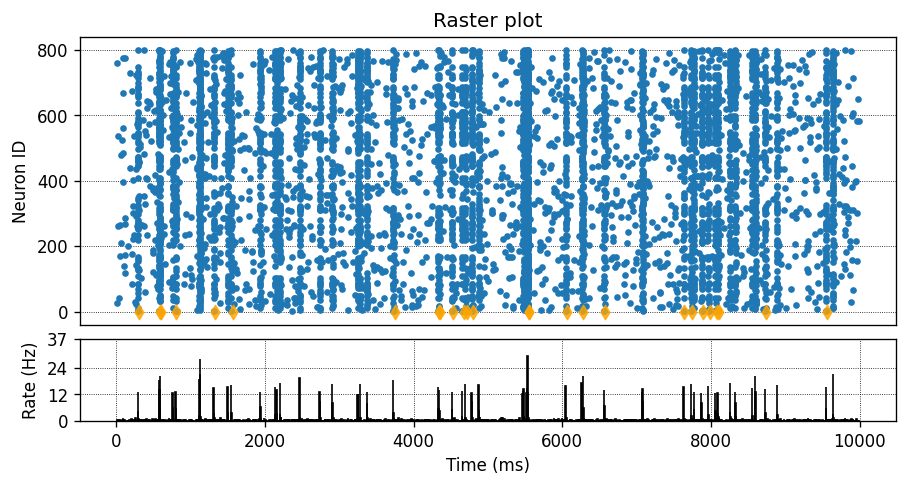

In [58]:
def _histogram(a, bins=10, bin_range=None, normed=False):
    """Calculate histogram for data.

    Parameters
    ----------
    a : list
        Data to calculate histogram for
    bins : int, optional
        Number of bins
    bin_range : TYPE, optional
        Range of bins
    normed : bool, optional
        Whether distribution should be normalized

    Raises
    ------
    ValueError
    """
    from numpy import asarray, iterable, linspace, sort, concatenate

    a = asarray(a).ravel()

    if bin_range is not None:
        mn, mx = bin_range
        if mn > mx:
            raise ValueError("max must be larger than min in range parameter")

    if not iterable(bins):
        if bin_range is None:
            bin_range = (a.min(), a.max())
        mn, mx = [mi + 0.0 for mi in bin_range]
        if mn == mx:
            mn -= 0.5
            mx += 0.5
        bins = linspace(mn, mx, bins, endpoint=False)
    else:
        if (bins[1:] - bins[:-1] < 0).any():
            raise ValueError("bins must increase monotonically")

    # best block size probably depends on processor cache size
    block = 65536
    n = sort(a[:block]).searchsorted(bins)
    for i in range(block, a.size, block):
        n += sort(a[i:i + block]).searchsorted(bins)
    n = concatenate([n, [len(a)]])
    n = n[1:] - n[:-1]

    if normed:
        db = bins[1] - bins[0]
        return 1.0 / (a.size * db) * n, bins
    else:
        return n, bins

def _make_plot(ts, ts1, node_ids, neurons, hist=True, hist_binwidth=5.0,
               grayscale=False, title=None, xlabel=None, t_dopa_spikes=None):
    """Generic plotting routine.

    Constructs a raster plot along with an optional histogram (common part in
    all routines above).

    Parameters
    ----------
    ts : list
        All timestamps
    ts1 : list
        Timestamps corresponding to node_ids
    node_ids : list
        Global ids corresponding to ts1
    neurons : list
        Node IDs of neurons to plot
    hist : bool, optional
        Display histogram
    hist_binwidth : float, optional
        Width of histogram bins
    grayscale : bool, optional
        Plot in grayscale
    title : str, optional
        Plot title
    xlabel : str, optional
        Label for x-axis
    """
    import matplotlib.pyplot as plt

    plt.figure()

    if grayscale:
        color_marker = ".k"
        color_bar = "gray"
    else:
        color_marker = "."
        color_bar = "blue"

    color_edge = "black"

    if xlabel is None:
        xlabel = "Time (ms)"

    ylabel = "Neuron ID"

    if hist:
        ax1 = plt.axes([0.1, 0.3, 0.85, 0.6])
        plotid = plt.plot(ts1, node_ids, color_marker)
        if t_dopa_spikes is not None:
            plt.scatter(t_dopa_spikes, np.zeros_like(t_dopa_spikes), marker="d", c="orange", alpha=.8, zorder=99)
        plt.ylabel(ylabel)
        plt.xticks([])
        xlim = plt.xlim()

        plt.axes([0.1, 0.1, 0.85, 0.17])
        t_bins = np.arange(
            np.amin(ts), np.amax(ts),
            float(hist_binwidth)
        )
        n, _ = _histogram(ts, bins=t_bins)
        num_neurons = len(np.unique(neurons))
        heights = 1000 * n / (hist_binwidth * num_neurons)

        plt.bar(t_bins, heights, width=hist_binwidth, color=color_bar,
                edgecolor=color_edge)
        plt.yticks([
            int(x) for x in
            np.linspace(0.0, int(max(heights) * 1.1) + 5, 4)
        ])
        plt.ylabel("Rate (Hz)")
        plt.xlabel(xlabel)
        plt.xlim(xlim)
        plt.axes(ax1)
    else:
        plotid = plt.plot(ts1, node_ids, color_marker)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

    if title is None:
        plt.title("Raster plot")
    else:
        plt.title(title)

    plt.draw()

    return plotid

ev = espikes.get("events")
ts, node_ids = ev["times"], ev["senders"]

_make_plot(ts, ts, node_ids, node_ids, xlabel="Time (ms)", t_dopa_spikes=t_dopa_spikes)

#plt.savefig("/tmp/stdp-dopa/raster.png")

### Plot membrane potential of 10 random excitatory cells

This helps to check if the network is in a balanced excitation/inhibition regime.

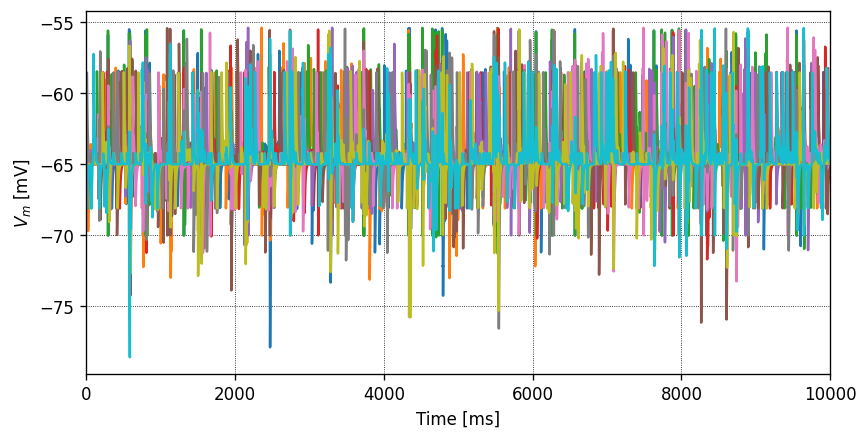

In [59]:
fig, ax = plt.subplots()
#ax.plot(mm.get("events")["times"],  mm.get("events")["V_m"], label="V_m")
for i in range(10):
    ax.plot(mms[i].get("events")["times"],  mms[i].get("events")["V_m"], label="V_m")
ax.set_xlim(0., total_t_sim)
ax.set_ylabel("$V_m$ [mV]")
ax.set_xlabel("Time [ms]")

None

### Timeseries

We should verify that the dopamine concentration is the same in group and nongroup neurons.

Note that the resolution (due to the chunking of the simulation) is too low here to see the faster dopamine dynamics. Use more chunks to increase the temporal resolution of this plot. Consider the relationship between $\tau_d$ and how many chunks we need to adequately visualize the dynamics.

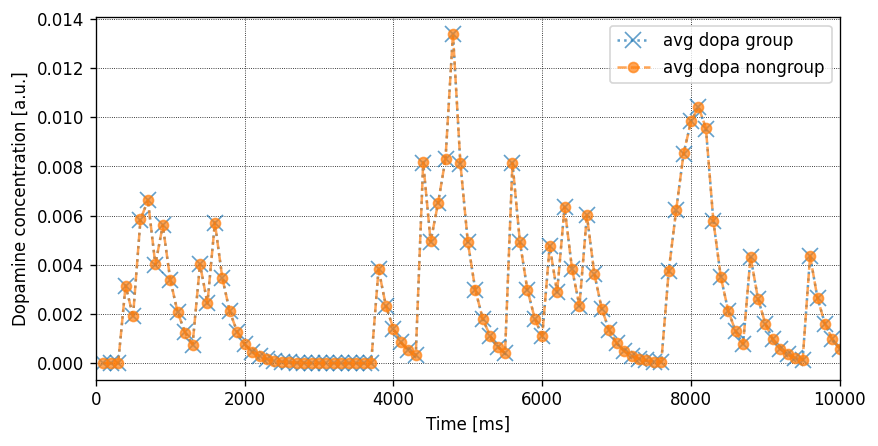

In [60]:
fig,ax = plt.subplots()

ax.plot(log["t"], log["reinforced_group"]["n_avg"], label="avg dopa group", linestyle=":", markersize=10, alpha=.7, marker="x")
ax.plot(log["t"], log["not_reinforced_group"]["n_avg"], label="avg dopa nongroup", linestyle="--", alpha=.7, marker="o")
ax.legend()

ax.set_xlim(0., total_t_sim)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Dopamine concentration [a.u.]")

None

In any case, all synapses seem to be receiving the same dopamine signal.

Now plot the average eligibility trace $c$ for group and nongroup neurons:

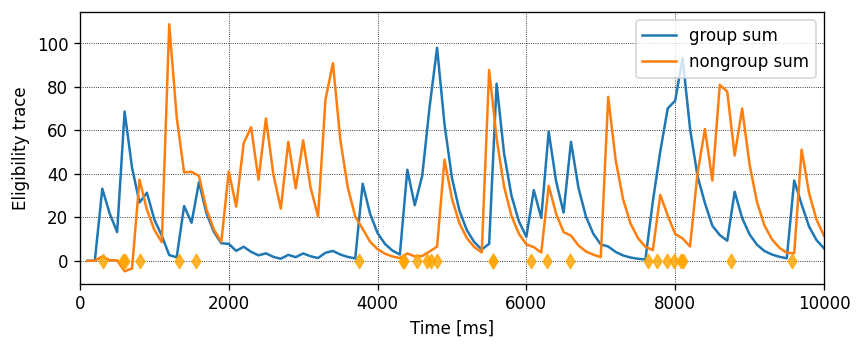

In [65]:
fig,ax = plt.subplots(figsize=(8, 3))
ax.plot(log["t"], log["reinforced_group"]["c_sum"], label="group sum")
ax.plot(log["t"], log["not_reinforced_group"]["c_sum"], label="nongroup sum")
ax.scatter(t_dopa_spikes, np.zeros_like(t_dopa_spikes), marker="d", c="orange", alpha=.8, zorder=99)
ax.set_xlim(0., total_t_sim)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Eligibility trace")
ax.legend()

None

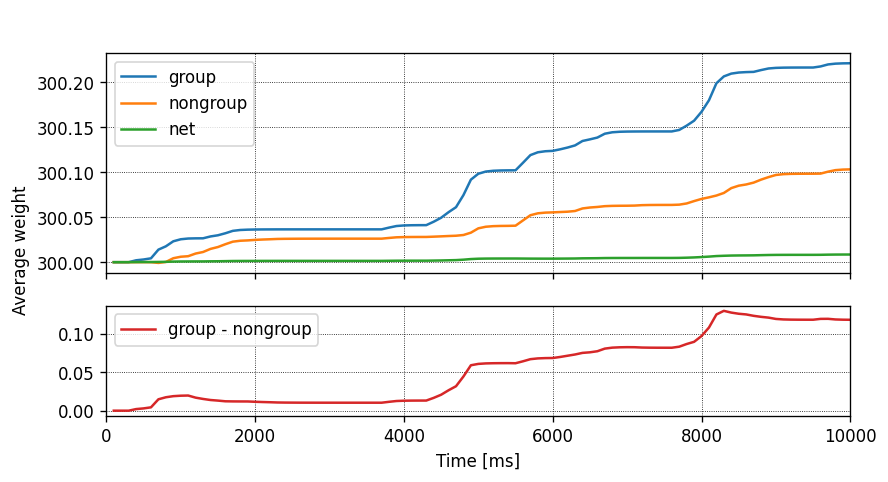

In [62]:
fig,ax = plt.subplots(nrows=2, gridspec_kw={"height_ratios": (2, 1)})

ax[0].plot(log["t"], log["reinforced_group"]["w_avg"], label="group")
ax[0].plot(log["t"], log["not_reinforced_group"]["w_avg"], label="nongroup")
ax[0].plot(log["t"], log["w_net"], label="net")
ax[1].plot(log["t"], np.array(log["reinforced_group"]["w_avg"]) - np.array(log["not_reinforced_group"]["w_avg"]),
           label="group - nongroup", c="tab:red")
for _ax in ax:
    _ax.legend()
    _ax.set_xlim(0., total_t_sim)

ax[-1].set_xlabel("Time [ms]")
ax[0].set_xticklabels([])
ax[0].set_ylabel("Average weight                                                                     ")

None

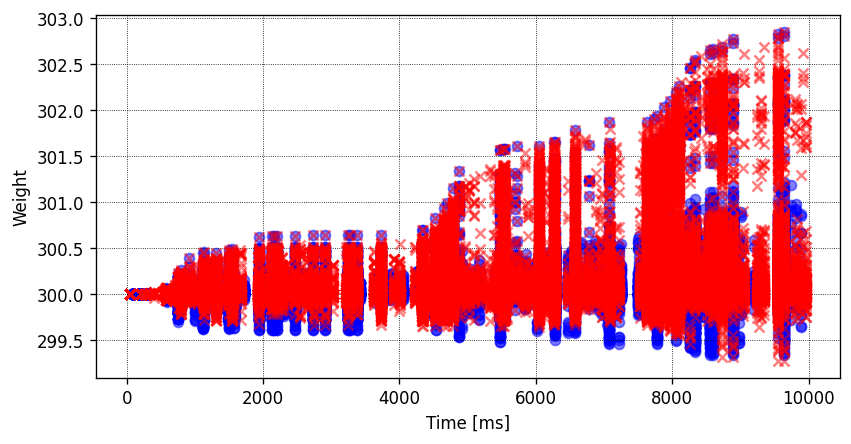

In [63]:
group_weight_times = [[] for _ in range(n_subgroups)]
group_weight_values = [[] for _ in range(n_subgroups)]
                                        
senders = np.array(wr.events["senders"])

for subgroup_idx in range(n_subgroups):
    nodes_ex_gids = nodes_ex[subgroup_indices[subgroup_idx]].tolist()
    idx = [np.where(senders == nodes_ex_gids[i])[0] for i in range(subgroup_size)]
    idx = [item for sublist in idx for item in sublist]
    group_weight_times[subgroup_idx] = wr.events["times"][idx]
    group_weight_values[subgroup_idx] = wr.events["weights"][idx]

fig, ax = plt.subplots()
for subgroup_idx in range(n_subgroups):
    if subgroup_idx == reinforced_subgroup_idx:
        c = "red"
        zorder = 99
        marker = "x"
    else:
        c = "blue"
        zorder=1
        marker = "o"
        
    ax.scatter(group_weight_times[subgroup_idx], group_weight_values[subgroup_idx], c=c, alpha=.5, zorder=zorder, marker=marker)

ax.set_ylabel("Weight")
ax.set_xlabel("Time [ms]")

None

# Citations
---------

[1] Mikaitis M, Pineda García G,
Knight JC and Furber SB (2018)
Neuromodulated Synaptic Plasticity
on the SpiNNaker Neuromorphic
System. Front. Neurosci. 12:105.
doi: 10.3389/fnins.2018.00105

[2] PyGeNN: A Python library for GPU-enhanced neural networks, James C. Knight, Anton Komissarov, Thomas Nowotny. Frontiers


Acknowledgements
----------------

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270, No. 785907 and No. 945539 (Human Brain Project SGA1, SGA2 and SGA3).

License
-------

This notebook (and associated files) is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

This notebook (and associated files) is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.